# Model 2: Residual Learning

This notebook implements Model 2 with residual learning:
- Compute per-user means from training data only
- Model predicts residuals (valence - mu_valence, arousal - mu_arousal)
- At inference: reconstructed = user_mean + predicted_residual
- Metrics computed on reconstructed absolute predictions
- Transformer frozen, only regression head trained


In [1]:
# Install dependencies
%pip install torch transformers pandas numpy scikit-learn matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random

# Configuration - Optimized for speed
DATA_PATH = 'TRAIN_RELEASE_3SEP2025/train_subtask1.csv'
EPOCHS = 10  # Reduced for faster training
BATCH_SIZE = 128  # Increased for faster training
MAX_LENGTH = 64  # Reduced for faster processing
LEARNING_RATE = 2e-5
MODEL_NAME = 'distilbert-base-uncased'
NORMALIZE = 'zscore'
USE_AMP = torch.cuda.is_available()  # Only use AMP on GPU
NUM_WORKERS = 0  # Faster on Windows, avoids multiprocessing overhead

# Random seed
RANDOM_SEED = random.randint(0, 10000)
print(f"Using random seed: {RANDOM_SEED}")

# Set all random seeds
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


e:\Abhijeet\After Arrival\Classes\Fall 25\NLP\SemEval2_\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using random seed: 29
Using device: cpu


## Model 2 Definition (Residual Learning)


In [3]:
class AffectDatasetResidual(Dataset):
    """Dataset for residual learning: predicts residuals, stores user means."""
    
    def __init__(self, texts, valences, arousals, user_ids, user_means_dict, 
                 global_mean_v, global_mean_a, tokenizer, max_length=64, 
                 normalize='zscore', scaler_valence=None, scaler_arousal=None):
        self.texts = texts
        self.user_ids = np.array(user_ids)
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        # Store original valences/arousals (for reconstruction)
        self.original_valences = np.array(valences)
        self.original_arousals = np.array(arousals)
        
        # Compute user means for each example (before normalization)
        self.user_mean_v = []
        self.user_mean_a = []
        for uid in user_ids:
            if uid in user_means_dict:
                self.user_mean_v.append(user_means_dict[uid]['valence'])
                self.user_mean_a.append(user_means_dict[uid]['arousal'])
            else:
                self.user_mean_v.append(global_mean_v)
                self.user_mean_a.append(global_mean_a)
        
        self.user_mean_v = np.array(self.user_mean_v)
        self.user_mean_a = np.array(self.user_mean_a)
        
        # Compute residual targets (before normalization)
        residual_valences = self.original_valences - self.user_mean_v
        residual_arousals = self.original_arousals - self.user_mean_a
        
        # Normalize targets (residuals)
        if scaler_valence is None or scaler_arousal is None:
            if normalize == 'zscore':
                self.scaler_valence = StandardScaler()
                self.scaler_arousal = StandardScaler()
            else:
                raise ValueError(f"Unknown normalization: {normalize}")
            self.valences = self.scaler_valence.fit_transform(residual_valences.reshape(-1, 1)).flatten()
            self.arousals = self.scaler_arousal.fit_transform(residual_arousals.reshape(-1, 1)).flatten()
        else:
            self.scaler_valence = scaler_valence
            self.scaler_arousal = scaler_arousal
            self.valences = self.scaler_valence.transform(residual_valences.reshape(-1, 1)).flatten()
            self.arousals = self.scaler_arousal.transform(residual_arousals.reshape(-1, 1)).flatten()
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.texts[idx]),
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'valence': torch.tensor(self.valences[idx], dtype=torch.float32),  # Residual target
            'arousal': torch.tensor(self.arousals[idx], dtype=torch.float32),  # Residual target
            'user_mean_v': torch.tensor(self.user_mean_v[idx], dtype=torch.float32),  # For reconstruction
            'user_mean_a': torch.tensor(self.user_mean_a[idx], dtype=torch.float32),  # For reconstruction
            'original_v': torch.tensor(self.original_valences[idx], dtype=torch.float32),  # For metrics
            'original_a': torch.tensor(self.original_arousals[idx], dtype=torch.float32)  # For metrics
        }

class AffectRegressorResidual(nn.Module):
    """Model 2: Text-only transformer predicting residuals."""
    
    def __init__(self, model_name='distilbert-base-uncased', dropout=0.1, freeze_encoder=True):
        super(AffectRegressorResidual, self).__init__()
        
        # Load pretrained transformer (frozen)
        self.encoder = AutoModel.from_pretrained(model_name)
        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False
        
        hidden_size = self.encoder.config.hidden_size
        
        # Regression head: predicts residuals only
        self.regressor = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 2)  # [res_valence, res_arousal]
        )
    
    def forward(self, input_ids, attention_mask):
        """Forward pass: predicts residuals only."""
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_representation = outputs.last_hidden_state[:, 0, :]
        residual_predictions = self.regressor(cls_representation)  # [batch, 2] residuals
        return residual_predictions

def get_model2_and_tokenizer(model_name='distilbert-base-uncased', freeze_encoder=True):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    model = AffectRegressorResidual(model_name=model_name, freeze_encoder=freeze_encoder)
    return model, tokenizer


In [4]:
def compute_metrics(pred_v, true_v, pred_a, true_a):
    """Compute metrics including correlation, MAE, and RAE."""
    mse_v = np.mean((pred_v - true_v) ** 2)
    mse_a = np.mean((pred_a - true_a) ** 2)
    mae_v = np.mean(np.abs(pred_v - true_v))
    mae_a = np.mean(np.abs(pred_a - true_a))
    
    # RAE (Relative Absolute Error)
    rae_v = mae_v / (np.mean(np.abs(true_v)) + 1e-8)
    rae_a = mae_a / (np.mean(np.abs(true_a)) + 1e-8)
    
    # R²
    ss_res_v = np.sum((true_v - pred_v) ** 2)
    ss_tot_v = np.sum((true_v - np.mean(true_v)) ** 2)
    r2_v = 1 - (ss_res_v / (ss_tot_v + 1e-8))
    
    ss_res_a = np.sum((true_a - pred_a) ** 2)
    ss_tot_a = np.sum((true_a - np.mean(true_a)) ** 2)
    r2_a = 1 - (ss_res_a / (ss_tot_a + 1e-8))
    
    # Pearson correlation (handle zero variance case)
    if len(pred_v) > 1:
        if np.std(pred_v) > 1e-8 and np.std(true_v) > 1e-8:
            corr_v = np.corrcoef(pred_v, true_v)[0, 1]
        else:
            corr_v = 0.0
    else:
        corr_v = 0.0
    
    if len(pred_a) > 1:
        if np.std(pred_a) > 1e-8 and np.std(true_a) > 1e-8:
            corr_a = np.corrcoef(pred_a, true_a)[0, 1]
        else:
            corr_a = 0.0
    else:
        corr_a = 0.0
    
    return {
        'valence_mse': mse_v, 'arousal_mse': mse_a,
        'valence_mae': mae_v, 'arousal_mae': mae_a,
        'valence_rae': rae_v, 'arousal_rae': rae_a,
        'valence_r2': r2_v, 'arousal_r2': r2_a,
        'valence_corr': corr_v, 'arousal_corr': corr_a
    }

def train_epoch(model, train_loader, criterion, optimizer, device, scaler=None):
    """Train for one epoch: loss on residuals."""
    model.train()
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        valence_residual = batch['valence'].to(device)  # Residual target
        arousal_residual = batch['arousal'].to(device)  # Residual target
        
        optimizer.zero_grad()
        residual_predictions = model(input_ids, attention_mask)  # Predicts residuals
        residual_targets = torch.stack([valence_residual, arousal_residual], dim=1)
        loss = criterion(residual_predictions, residual_targets)  # Loss on residuals
        
        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

def evaluate_model(model, val_loader, scaler_valence, scaler_arousal, device, scaler=None):
    """Evaluate: reconstruct absolute predictions, compute metrics on absolutes."""
    model.eval()
    all_pred_residuals = []
    all_user_means_v = []
    all_user_means_a = []
    all_original_v = []
    all_original_a = []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            # Predict residuals
            residual_predictions = model(input_ids, attention_mask)
            
            # Get user means and original targets
            user_mean_v = batch['user_mean_v'].cpu().numpy()
            user_mean_a = batch['user_mean_a'].cpu().numpy()
            original_v = batch['original_v'].cpu().numpy()
            original_a = batch['original_a'].cpu().numpy()
            
            all_pred_residuals.append(residual_predictions.cpu().numpy())
            all_user_means_v.append(user_mean_v)
            all_user_means_a.append(user_mean_a)
            all_original_v.append(original_v)
            all_original_a.append(original_a)
    
    # Concatenate
    pred_residuals = np.concatenate(all_pred_residuals, axis=0)
    user_means_v = np.concatenate(all_user_means_v)
    user_means_a = np.concatenate(all_user_means_a)
    original_v = np.concatenate(all_original_v)
    original_a = np.concatenate(all_original_a)
    
    # Denormalize residuals
    pred_res_v_norm = pred_residuals[:, 0]
    pred_res_a_norm = pred_residuals[:, 1]
    pred_res_v = scaler_valence.inverse_transform(pred_res_v_norm.reshape(-1, 1)).flatten()
    pred_res_a = scaler_arousal.inverse_transform(pred_res_a_norm.reshape(-1, 1)).flatten()
    
    # Reconstruct absolute predictions
    pred_v_absolute = user_means_v + pred_res_v
    pred_a_absolute = user_means_a + pred_res_a
    
    # Compute metrics on absolute predictions
    return compute_metrics(pred_v_absolute, original_v, pred_a_absolute, original_a)


In [5]:
# Load data
df = pd.read_csv(DATA_PATH)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['user_id', 'timestamp']).reset_index(drop=True)

print(f"Loaded {len(df)} samples")
print(f"Unique users: {df['user_id'].nunique()}")

# Split into train and validation
train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=RANDOM_SEED, shuffle=True
)

print(f"Train: {len(train_df)}, Val: {len(val_df)}")

# Compute per-user means from TRAINING DATA ONLY
user_means = train_df.groupby('user_id')[['valence', 'arousal']].mean()
global_mean_v = train_df['valence'].mean()
global_mean_a = train_df['arousal'].mean()

# Create user_means_dict for easy lookup
user_means_dict = {}
for user_id, row in user_means.iterrows():
    user_means_dict[user_id] = {
        'valence': row['valence'],
        'arousal': row['arousal']
    }

print(f"Computed per-user means for {len(user_means_dict)} users")
print(f"Global mean - Valence: {global_mean_v:.4f}, Arousal: {global_mean_a:.4f}")

# Get model and tokenizer
model, tokenizer = get_model2_and_tokenizer(MODEL_NAME, freeze_encoder=True)
model = model.to(device)

# Create datasets with residual learning
train_dataset = AffectDatasetResidual(
    texts=train_df['text'].tolist(),
    valences=train_df['valence'].tolist(),
    arousals=train_df['arousal'].tolist(),
    user_ids=train_df['user_id'].tolist(),
    user_means_dict=user_means_dict,
    global_mean_v=global_mean_v,
    global_mean_a=global_mean_a,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    normalize=NORMALIZE
)

scaler_valence = train_dataset.scaler_valence
scaler_arousal = train_dataset.scaler_arousal

val_dataset = AffectDatasetResidual(
    texts=val_df['text'].tolist(),
    valences=val_df['valence'].tolist(),
    arousals=val_df['arousal'].tolist(),
    user_ids=val_df['user_id'].tolist(),
    user_means_dict=user_means_dict,
    global_mean_v=global_mean_v,
    global_mean_a=global_mean_a,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    normalize=NORMALIZE,
    scaler_valence=scaler_valence,
    scaler_arousal=scaler_arousal
)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


Loaded 2764 samples
Unique users: 137
Train: 2211, Val: 553
Computed per-user means for 136 users
Global mean - Valence: 0.2406, Arousal: 0.7472


## Baselines (Same as Model 1)


In [ ]:
# Baseline 1: Global Mean Predictor
def global_mean_baseline(train_df, val_df):
    """Predict global mean from training set."""
    mean_v = train_df['valence'].mean()
    mean_a = train_df['arousal'].mean()
    
    pred_v = np.full(len(val_df), mean_v)
    pred_a = np.full(len(val_df), mean_a)
    true_v = val_df['valence'].values
    true_a = val_df['arousal'].values       
    
    return compute_metrics(pred_v, true_v, pred_a, true_a)

# Baseline 2: Per-User Mean Predictor
def per_user_mean_baseline(train_df, val_df):
    """For seen users: use their training mean. For unseen: use global mean."""
    global_mean_v = train_df['valence'].mean()
    global_mean_a = train_df['arousal'].mean()
    
    # Compute per-user means from training
    user_means = train_df.groupby('user_id')[['valence', 'arousal']].mean()
    train_users = set(train_df['user_id'].unique())
    
    pred_v = []
    pred_a = []
    true_v = []
    true_a = []
    
    for _, row in val_df.iterrows():
        user_id = row['user_id']
        if user_id in train_users:
            pred_v.append(user_means.loc[user_id, 'valence'])
            pred_a.append(user_means.loc[user_id, 'arousal'])
        else:
            pred_v.append(global_mean_v)
            pred_a.append(global_mean_a)
        true_v.append(row['valence'])
        true_a.append(row['arousal'])
    
    return compute_metrics(np.array(pred_v), np.array(true_v), 
                          np.array(pred_a), np.array(true_a))

# Baseline 3: Persistence/Lag Baseline
def persistence_baseline(train_df, val_df):
    """Predict previous value. For first entry per user, use their training mean or global mean."""
    global_mean_v = train_df['valence'].mean()
    global_mean_a = train_df['arousal'].mean()
    
    user_means = train_df.groupby('user_id')[['valence', 'arousal']].mean()
    train_users = set(train_df['user_id'].unique())
    
    # Store last values per user
    last_values = {}
    for user_id in train_users:
        user_train = train_df[train_df['user_id'] == user_id].sort_values('timestamp')
        if len(user_train) > 0:
            last_values[user_id] = {
                'valence': user_train.iloc[-1]['valence'],
                'arousal': user_train.iloc[-1]['arousal']
            }
    
    pred_v = []
    pred_a = []
    true_v = []
    true_a = []
    
    val_df_sorted = val_df.sort_values(['user_id', 'timestamp']).reset_index(drop=True)
    
    for _, row in val_df_sorted.iterrows():
        user_id = row['user_id']
        if user_id in last_values:
            pred_v.append(last_values[user_id]['valence'])
            pred_a.append(last_values[user_id]['arousal'])
            # Update for next prediction
            last_values[user_id] = {'valence': row['valence'], 'arousal': row['arousal']}
        elif user_id in train_users:
            # First entry for seen user, use their training mean
            pred_v.append(user_means.loc[user_id, 'valence'])
            pred_a.append(user_means.loc[user_id, 'arousal'])
            last_values[user_id] = {'valence': row['valence'], 'arousal': row['arousal']}
        else:
            # Unseen user, use global mean
            pred_v.append(global_mean_v)
            pred_a.append(global_mean_a)
            last_values[user_id] = {'valence': row['valence'], 'arousal': row['arousal']}
        
        true_v.append(row['valence'])
        true_a.append(row['arousal'])
    
    return compute_metrics(np.array(pred_v), np.array(true_v), 
                          np.array(pred_a), np.array(true_a))

# Compute baseline metrics
print("Computing baseline metrics...")
baseline_global = global_mean_baseline(train_df, val_df)
baseline_per_user = per_user_mean_baseline(train_df, val_df)
baseline_persistence = persistence_baseline(train_df, val_df)

print("\n=== Baseline Results ===")
print(f"Global Mean:")
print(f"  Valence - Corr: {baseline_global['valence_corr']:.4f}, MAE: {baseline_global['valence_mae']:.4f}, RAE: {baseline_global['valence_rae']:.4f}")
print(f"  Arousal - Corr: {baseline_global['arousal_corr']:.4f}, MAE: {baseline_global['arousal_mae']:.4f}, RAE: {baseline_global['arousal_rae']:.4f}")
print(f"Per-User Mean:")
print(f"  Valence - Corr: {baseline_per_user['valence_corr']:.4f}, MAE: {baseline_per_user['valence_mae']:.4f}, RAE: {baseline_per_user['valence_rae']:.4f}")
print(f"  Arousal - Corr: {baseline_per_user['arousal_corr']:.4f}, MAE: {baseline_per_user['arousal_mae']:.4f}, RAE: {baseline_per_user['arousal_rae']:.4f}")
print(f"Persistence:")
print(f"  Valence - Corr: {baseline_persistence['valence_corr']:.4f}, MAE: {baseline_persistence['valence_mae']:.4f}, RAE: {baseline_persistence['valence_rae']:.4f}")
print(f"  Arousal - Corr: {baseline_persistence['arousal_corr']:.4f}, MAE: {baseline_persistence['arousal_mae']:.4f}, RAE: {baseline_persistence['arousal_rae']:.4f}")


Computing baseline metrics...

=== Baseline Results ===
Global Mean:
  Valence - Corr: 0.0000, MAE: 1.1033, RAE: 1.0501
  Arousal - Corr: 0.0000, MAE: 0.6789, RAE: 0.8855
Per-User Mean:
  Valence - Corr: 0.4588, MAE: 0.9159, RAE: 0.8717
  Arousal - Corr: 0.3707, MAE: 0.5827, RAE: 0.7600
Persistence:
  Valence - Corr: 0.2858, MAE: 1.1180, RAE: 1.0641
  Arousal - Corr: 0.2097, MAE: 0.6732, RAE: 0.8780


## Model 2 Training


In [7]:
# Loss and optimizer (only trainable params: user embedding + regressor)
criterion = nn.MSELoss()
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(trainable_params, lr=LEARNING_RATE, weight_decay=1e-4)  # L2 regularization
scaler = torch.cuda.amp.GradScaler() if USE_AMP else None

# Track metrics per epoch
epoch_metrics = {
    'valence_corr': [], 'arousal_corr': [],
    'valence_mae': [], 'arousal_mae': [],
    'valence_rae': [], 'arousal_rae': []
}

# Training loop with CSV saving
best_val_corr = -float('inf')
best_metrics = None
epoch_metrics = {
    'epoch': [],
    'valence_corr': [], 'arousal_corr': [],
    'valence_mae': [], 'arousal_mae': [],
    'valence_rae': [], 'arousal_rae': []
}

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_epoch(model, train_loader, criterion, optimizer, device, scaler=scaler)
    metrics = evaluate_model(model, val_loader, scaler_valence, scaler_arousal, device, scaler=scaler)
    
    # Store metrics
    epoch_metrics['epoch'].append(epoch + 1)
    epoch_metrics['valence_corr'].append(metrics['valence_corr'])
    epoch_metrics['arousal_corr'].append(metrics['arousal_corr'])
    epoch_metrics['valence_mae'].append(metrics['valence_mae'])
    epoch_metrics['arousal_mae'].append(metrics['arousal_mae'])
    epoch_metrics['valence_rae'].append(metrics['valence_rae'])
    epoch_metrics['arousal_rae'].append(metrics['arousal_rae'])
    
    avg_corr = (metrics['valence_corr'] + metrics['arousal_corr']) / 2
    if avg_corr > best_val_corr:
        best_val_corr = avg_corr
        best_metrics = metrics.copy()
        torch.save(model.state_dict(), 'best_model2.pth')
    
    print(f"  Valence - Corr: {metrics['valence_corr']:.3f}, MAE: {metrics['valence_mae']:.3f}, RAE: {metrics['valence_rae']:.3f}")
    print(f"  Arousal - Corr: {metrics['arousal_corr']:.3f}, MAE: {metrics['arousal_mae']:.3f}, RAE: {metrics['arousal_rae']:.3f}")

# Save epoch metrics to CSV
metrics_df = pd.DataFrame(epoch_metrics)
metrics_df.to_csv('model2_metrics.csv', index=False)
print(f"\nSaved epoch metrics to model2_metrics.csv")

print(f"\nBest Model:")
print(f"  Valence - Corr: {best_metrics['valence_corr']:.3f}, MAE: {best_metrics['valence_mae']:.3f}, RAE: {best_metrics['valence_rae']:.3f}")
print(f"  Arousal - Corr: {best_metrics['arousal_corr']:.3f}, MAE: {best_metrics['arousal_mae']:.3f}, RAE: {best_metrics['arousal_rae']:.3f}")


Epoch 1/10
  Valence - Corr: 0.467, MAE: 0.912, RAE: 0.868
  Arousal - Corr: 0.373, MAE: 0.583, RAE: 0.760
Epoch 2/10
  Valence - Corr: 0.478, MAE: 0.905, RAE: 0.862
  Arousal - Corr: 0.375, MAE: 0.582, RAE: 0.759
Epoch 3/10
  Valence - Corr: 0.489, MAE: 0.900, RAE: 0.857
  Arousal - Corr: 0.377, MAE: 0.582, RAE: 0.759
Epoch 4/10
  Valence - Corr: 0.499, MAE: 0.895, RAE: 0.852
  Arousal - Corr: 0.380, MAE: 0.581, RAE: 0.758
Epoch 5/10
  Valence - Corr: 0.509, MAE: 0.890, RAE: 0.847
  Arousal - Corr: 0.382, MAE: 0.581, RAE: 0.757
Epoch 6/10
  Valence - Corr: 0.519, MAE: 0.886, RAE: 0.843
  Arousal - Corr: 0.385, MAE: 0.580, RAE: 0.756
Epoch 7/10
  Valence - Corr: 0.527, MAE: 0.883, RAE: 0.840
  Arousal - Corr: 0.387, MAE: 0.579, RAE: 0.756
Epoch 8/10
  Valence - Corr: 0.536, MAE: 0.878, RAE: 0.835
  Arousal - Corr: 0.391, MAE: 0.578, RAE: 0.754
Epoch 9/10
  Valence - Corr: 0.544, MAE: 0.873, RAE: 0.831
  Arousal - Corr: 0.393, MAE: 0.577, RAE: 0.753
Epoch 10/10
  Valence - Corr: 0.552, 

## Comparison Plots: Model 2 vs Model 1 vs Baselines


Loaded Model 1 metrics from model1_metrics.csv


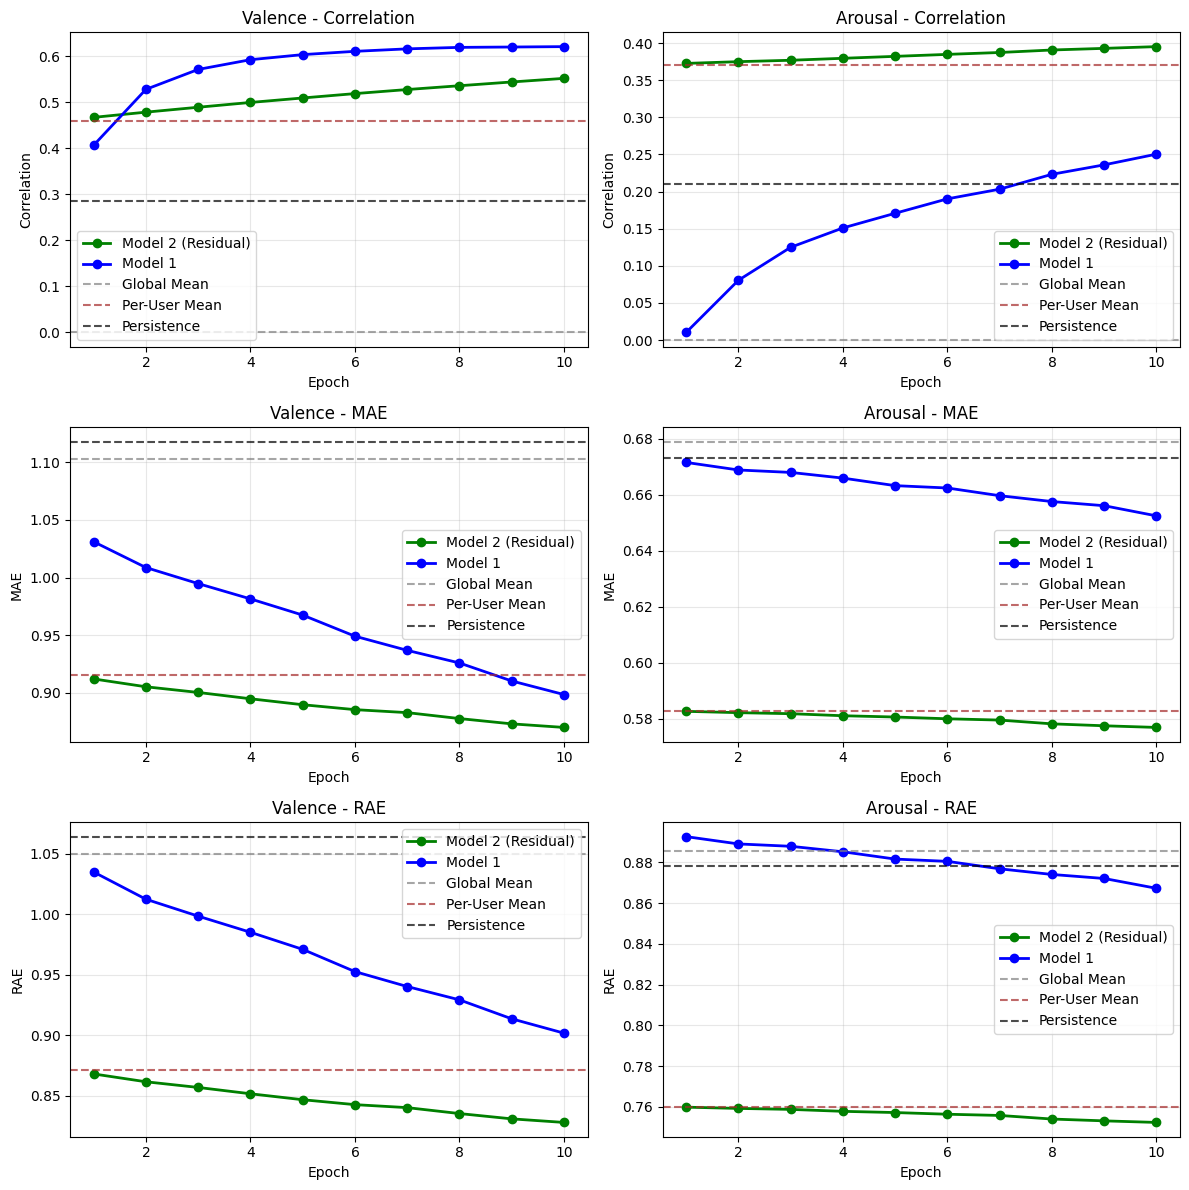


Method               Metric          Valence      Arousal     
------------------------------------------------------------
Model 2 (Residual)   Correlation     0.552        0.395       
Model 2 (Residual)   MAE             0.870        0.577       
Model 2 (Residual)   RAE             0.828        0.752       
Global Mean          Correlation     0.000        0.000       
Global Mean          MAE             1.103        0.679       
Global Mean          RAE             1.050        0.885       
Per-User Mean        Correlation     0.459        0.371       
Per-User Mean        MAE             0.916        0.583       
Per-User Mean        RAE             0.872        0.760       
Persistence          Correlation     0.286        0.210       
Persistence          MAE             1.118        0.673       
Persistence          RAE             1.064        0.878       


In [8]:
# Load Model 1 metrics from CSV
try:
    model1_metrics = pd.read_csv('model1_metrics.csv')
    model1_epoch_metrics = {
        'valence_corr': model1_metrics['valence_corr'].tolist(),
        'arousal_corr': model1_metrics['arousal_corr'].tolist(),
        'valence_mae': model1_metrics['valence_mae'].tolist(),
        'arousal_mae': model1_metrics['arousal_mae'].tolist(),
        'valence_rae': model1_metrics['valence_rae'].tolist(),
        'arousal_rae': model1_metrics['arousal_rae'].tolist()
    }
    epochs = model1_metrics['epoch'].tolist()
    print("Loaded Model 1 metrics from model1_metrics.csv")
except FileNotFoundError:
    print("Warning: model1_metrics.csv not found. Using Model 2 epochs only.")
    epochs = epoch_metrics['epoch'] if 'epoch' in epoch_metrics else list(range(1, EPOCHS + 1))
    model1_epoch_metrics = None

# Create comparison plots: 3 rows x 2 columns (Correlation, MAE, RAE)
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Row 1: Correlation
ax1, ax2 = axes[0, 0], axes[0, 1]
ax1.plot(epochs, epoch_metrics['valence_corr'], 'o-', label='Model 2 (Residual)', linewidth=2, color='green')
if model1_epoch_metrics:
    ax1.plot(epochs, model1_epoch_metrics['valence_corr'], 'o-', label='Model 1', linewidth=2, color='blue')
ax1.axhline(y=baseline_global['valence_corr'], linestyle='--', label='Global Mean', color='grey', alpha=0.7)
ax1.axhline(y=baseline_per_user['valence_corr'], linestyle='--', label='Per-User Mean', color='brown', alpha=0.7)
ax1.axhline(y=baseline_persistence['valence_corr'], linestyle='--', label='Persistence', color='black', alpha=0.7)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Correlation')
ax1.set_title('Valence - Correlation')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(epochs, epoch_metrics['arousal_corr'], 'o-', label='Model 2 (Residual)', linewidth=2, color='green')
if model1_epoch_metrics:
    ax2.plot(epochs, model1_epoch_metrics['arousal_corr'], 'o-', label='Model 1', linewidth=2, color='blue')
ax2.axhline(y=baseline_global['arousal_corr'], linestyle='--', label='Global Mean', color='grey', alpha=0.7)
ax2.axhline(y=baseline_per_user['arousal_corr'], linestyle='--', label='Per-User Mean', color='brown', alpha=0.7)
ax2.axhline(y=baseline_persistence['arousal_corr'], linestyle='--', label='Persistence', color='black', alpha=0.7)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Correlation')
ax2.set_title('Arousal - Correlation')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Row 2: MAE
ax3, ax4 = axes[1, 0], axes[1, 1]
ax3.plot(epochs, epoch_metrics['valence_mae'], 'o-', label='Model 2 (Residual)', linewidth=2, color='green')
if model1_epoch_metrics:
    ax3.plot(epochs, model1_epoch_metrics['valence_mae'], 'o-', label='Model 1', linewidth=2, color='blue')
ax3.axhline(y=baseline_global['valence_mae'], linestyle='--', label='Global Mean', color='grey', alpha=0.7)
ax3.axhline(y=baseline_per_user['valence_mae'], linestyle='--', label='Per-User Mean', color='brown', alpha=0.7)
ax3.axhline(y=baseline_persistence['valence_mae'], linestyle='--', label='Persistence', color='black', alpha=0.7)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('MAE')
ax3.set_title('Valence - MAE')
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4.plot(epochs, epoch_metrics['arousal_mae'], 'o-', label='Model 2 (Residual)', linewidth=2, color='green')
if model1_epoch_metrics:
    ax4.plot(epochs, model1_epoch_metrics['arousal_mae'], 'o-', label='Model 1', linewidth=2, color='blue')
ax4.axhline(y=baseline_global['arousal_mae'], linestyle='--', label='Global Mean', color='grey', alpha=0.7)
ax4.axhline(y=baseline_per_user['arousal_mae'], linestyle='--', label='Per-User Mean', color='brown', alpha=0.7)
ax4.axhline(y=baseline_persistence['arousal_mae'], linestyle='--', label='Persistence', color='black', alpha=0.7)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('MAE')
ax4.set_title('Arousal - MAE')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Row 3: RAE
ax5, ax6 = axes[2, 0], axes[2, 1]
ax5.plot(epochs, epoch_metrics['valence_rae'], 'o-', label='Model 2 (Residual)', linewidth=2, color='green')
if model1_epoch_metrics:
    ax5.plot(epochs, model1_epoch_metrics['valence_rae'], 'o-', label='Model 1', linewidth=2, color='blue')
ax5.axhline(y=baseline_global['valence_rae'], linestyle='--', label='Global Mean', color='grey', alpha=0.7)
ax5.axhline(y=baseline_per_user['valence_rae'], linestyle='--', label='Per-User Mean', color='brown', alpha=0.7)
ax5.axhline(y=baseline_persistence['valence_rae'], linestyle='--', label='Persistence', color='black', alpha=0.7)
ax5.set_xlabel('Epoch')
ax5.set_ylabel('RAE')
ax5.set_title('Valence - RAE')
ax5.legend()
ax5.grid(True, alpha=0.3)

ax6.plot(epochs, epoch_metrics['arousal_rae'], 'o-', label='Model 2 (Residual)', linewidth=2, color='green')
if model1_epoch_metrics:
    ax6.plot(epochs, model1_epoch_metrics['arousal_rae'], 'o-', label='Model 1', linewidth=2, color='blue')
ax6.axhline(y=baseline_global['arousal_rae'], linestyle='--', label='Global Mean', color='grey', alpha=0.7)
ax6.axhline(y=baseline_per_user['arousal_rae'], linestyle='--', label='Per-User Mean', color='brown', alpha=0.7)
ax6.axhline(y=baseline_persistence['arousal_rae'], linestyle='--', label='Persistence', color='black', alpha=0.7)
ax6.set_xlabel('Epoch')
ax6.set_ylabel('RAE')
ax6.set_title('Arousal - RAE')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary with explicit Valence/Arousal labels and MAE, RAE
print(f"\n{'Method':<20} {'Metric':<15} {'Valence':<12} {'Arousal':<12}")
print("-" * 60)
print(f"{'Model 2 (Residual)':<20} {'Correlation':<15} {best_metrics['valence_corr']:<12.3f} {best_metrics['arousal_corr']:<12.3f}")
print(f"{'Model 2 (Residual)':<20} {'MAE':<15} {best_metrics['valence_mae']:<12.3f} {best_metrics['arousal_mae']:<12.3f}")
print(f"{'Model 2 (Residual)':<20} {'RAE':<15} {best_metrics['valence_rae']:<12.3f} {best_metrics['arousal_rae']:<12.3f}")
print(f"{'Global Mean':<20} {'Correlation':<15} {baseline_global['valence_corr']:<12.3f} {baseline_global['arousal_corr']:<12.3f}")
print(f"{'Global Mean':<20} {'MAE':<15} {baseline_global['valence_mae']:<12.3f} {baseline_global['arousal_mae']:<12.3f}")
print(f"{'Global Mean':<20} {'RAE':<15} {baseline_global['valence_rae']:<12.3f} {baseline_global['arousal_rae']:<12.3f}")
print(f"{'Per-User Mean':<20} {'Correlation':<15} {baseline_per_user['valence_corr']:<12.3f} {baseline_per_user['arousal_corr']:<12.3f}")
print(f"{'Per-User Mean':<20} {'MAE':<15} {baseline_per_user['valence_mae']:<12.3f} {baseline_per_user['arousal_mae']:<12.3f}")
print(f"{'Per-User Mean':<20} {'RAE':<15} {baseline_per_user['valence_rae']:<12.3f} {baseline_per_user['arousal_rae']:<12.3f}")
print(f"{'Persistence':<20} {'Correlation':<15} {baseline_persistence['valence_corr']:<12.3f} {baseline_persistence['arousal_corr']:<12.3f}")
print(f"{'Persistence':<20} {'MAE':<15} {baseline_persistence['valence_mae']:<12.3f} {baseline_persistence['arousal_mae']:<12.3f}")
print(f"{'Persistence':<20} {'RAE':<15} {baseline_persistence['valence_rae']:<12.3f} {baseline_persistence['arousal_rae']:<12.3f}")
